In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import os
import tqdm
import torch
import pickle
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models
from gumbel import gumbel_softmax_new
from fede.distance_image import Distance_Image
from toolz.curried import pipe, curry, compose
from fede.distance_senteces import Distance_Sentences
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence

In [3]:
#sample.py
from torchvision import transforms 
from build_vocab import Vocabulary
#train.py
from data_loader import get_loader

In [9]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

In [4]:
%%bash
nvidia-smi

Tue Apr 30 19:14:16 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.30                 Driver Version: 390.30                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:02:00.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |     10MiB / 16280MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:03:00.0 Off |                    0 |
| N/A   28C    P0    26W / 250W |     10MiB / 16280MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   2  T

In [5]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features
    
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)

        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids 


class Generator(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(Generator, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, states=None, temp=1.0, hard=False):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            outputs = gumbel_softmax_new(outputs, temp, hard, device=device)
            _, predicted = outputs.max(1)                        # predicted: (batch_size) #greedy heuristic
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)

        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids 
    
    
class SentenceEmbedder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(SentenceEmbedder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, captions):
        embeddings = self.embed(captions)
        embeddings, _ = self.lstm(embeddings)
        return embeddings

    
class ImageEmbedder(nn.Module):
    def __init__(self, embed_size, hidden_size):
        """Set the hyper-parameters and build the layers."""
        super(ImageEmbedder, self).__init__()
        self.linear = nn.Linear(embed_size, hidden_size)
        
    def forward(self, features):
        embeddings = self.linear(features)
        return embeddings
    
class Discriminator(nn.Module):
    def __init__(self, 
                 N=128, 
                 O=128,
                 w_emb_size=512, 
                 i_emb_size=512, 
                 set_size=5, 
                 device = torch.device("cpu")):
        
        super(Discriminator, self).__init__()

        self.device = device 
        self.distance_layer_sentences = Distance_Sentences(w_emb_size, N, O)
        self.distance_layer_images = Distance_Image(w_emb_size, N, O, i_emb_size)
        self.set_size = set_size
        self.projection = nn.Linear((self.set_size+1)*O, 2)
        
        
    def forward(self, w_emb, i_emb):
        o_sentence = self.distance_layer_sentences(w_emb)
        o_image = self.distance_layer_images.forward(w_emb, i_emb)
        o = torch.cat((o_image, o_sentence), 1).to(self.device)        
        D = nn.functional.log_softmax(self.projection(o),dim=1)        
        return D

In [52]:
class Args():
    model_path = 'full_models_nb'
    crop_size = 224
    vocab_path = 'data/vocab.pkl'
    image_dir = 'data/resized2014'
    caption_path = 'data/annotations/captions_train2014.json'
    log_step = 10
    save_step = 1000
    embed_size = 256
    hidden_size = 512
    num_layers = 1
    num_epochs = 1
    batch_size = 1
    num_workers = 4
    learning_rate = 0.001
    cuda = True
args = Args()

if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)
    
device = torch.device("cuda:1")

transform = transforms.Compose([ 
    transforms.RandomCrop(args.crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])


with open(args.vocab_path, 'rb') as f:
    vocab = pickle.load(f)
print("Size of Vocabulary: %d" % len(vocab))

data_loader = get_loader(args.image_dir, args.caption_path, vocab, 
                         transform, args.batch_size,
                         shuffle=True, num_workers=args.num_workers)

Size of Vocabulary: 9956
loading annotations into memory...
Done (t=1.02s)
creating index...
index created!


In [53]:
%%time
encoder = EncoderCNN(args.embed_size).to(device).eval()
decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers).to(device)
generator = Generator(args.embed_size, args.hidden_size, len(vocab), args.num_layers).to(device)
sent_embedder = SentenceEmbedder(args.embed_size, args.hidden_size, len(vocab), args.num_layers).to(device)
img_embedder = ImageEmbedder(args.embed_size, args.hidden_size).to(device)
discriminator = Discriminator(device=device).to(device)

encoder_path = "models/encoder-2-1000.ckpt"
decoder_path = "models/decoder-2-1000.ckpt"

encoder.load_state_dict(torch.load(encoder_path, map_location=torch.device("cpu")))
decoder.load_state_dict(torch.load(decoder_path, map_location=torch.device("cpu")))
generator.load_state_dict(torch.load(decoder_path, map_location=torch.device("cpu")))
sent_embedder.load_state_dict(torch.load(decoder_path, map_location=torch.device("cpu")))

CPU times: user 1.75 s, sys: 684 ms, total: 2.43 s
Wall time: 4.73 s


In [10]:
# file_path = "png/cat_kiss.jpeg"
# file_path = "png/kids-beach-playing-600jt082213.jpg"
file_path = "png/david.jpeg"
# file_path = "png/berkay.jpeg"
# file_path = "png/batter.png"
# file_path = "png/girl_on_rock.png"
image = load_image(file_path, transform)
if image.shape[2] > 3:
    image = image[:,:3]
images = image.clone()
print("input single image: ", images.shape)


images_set = []
for i in range(5):
    noise = (torch.rand_like(images) - 0.5) * 0.000
    if i > 0:
        images_set.append(images+noise)
    else:
        images_set.append(images)
        
images_set = torch.cat(images_set, dim=0).to(device)
print("output many images", images_set.shape)
features = encoder(images_set)


temp = .5
hard = False
sampled_ids = generator(features, temp=temp, hard=hard)


for idx in range(5):
    sampled_caption = []
    for word_id in sampled_ids[idx]:
        word = vocab.idx2word[word_id.item()]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    print(sentence + "\n")

input single image:  torch.Size([1, 3, 224, 224])
output many images torch.Size([5, 3, 224, 224])
<start> the interior are spread out kind of volley with monitors . <end>

<start> a neatly organized system sitting on top of a desk <end>

<start> a teen room with a desk with a laptop computer next to it . <end>

<start> a tv on a desk with files holding a gaming controller in front . <end>

<start> a full view of a desk playing with a book . <end>



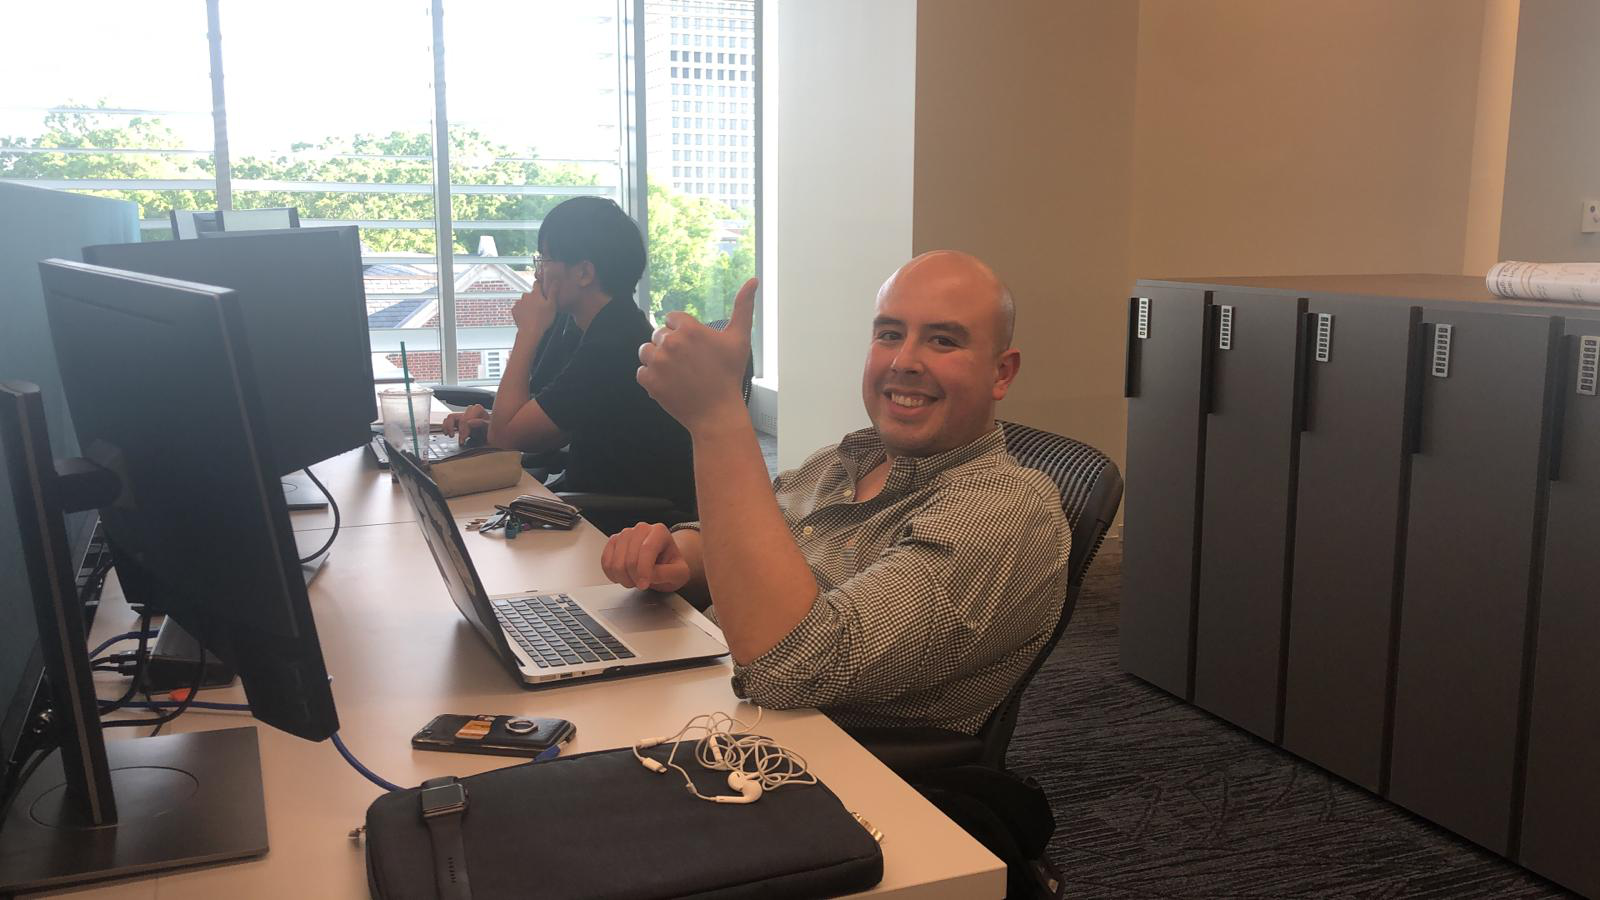

In [11]:
Image.open(file_path)

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params, lr=args.learning_rate)
training_losses = []
total_step = len(data_loader)

In [58]:
for epoch in range(args.num_epochs):
    for i, (images, captions, lengths) in enumerate(tqdm.tqdm_notebook(data_loader)):
        images_set = []
        captions_set = []
        for indx in range(5):
            noise = (torch.rand_like(images) - 0.5) * 0.000
            if indx > 0:
                images_set.append(images+noise)
            else:
                images_set.append(images)
            captions_set.append(captions)

        images_set = torch.cat(images_set, dim=0).to(device)
        captions_set = torch.cat(captions_set, dim=0).to(device)

        features = encoder(images_set)
        toss = torch.rand(1)

        if toss > 0.3:
            sampled_ids = generator(features, temp=0.5, hard=False)
            w_emb = sent_embedder(sampled_ids)
            t = torch.tensor([0]).to(device)
        else:
            w_emb = sent_embedder(captions_set)
            t = torch.tensor([1]).to(device)

        i_emb = img_embedder(features)
        d = discriminator(w_emb[:,-1,:][None], i_emb[0][None]) 

        loss = criterion(d, t)

        generator.zero_grad()
        discriminator.zero_grad()
        encoder.zero_grad()
        sent_embedder.zero_grad()
        img_embedder.zero_grad()

        loss.backward()
        optimizer.step()

            # Print log info
        if i % args.log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, args.num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 
            training_losses.append(loss.item())

In [41]:
vocab_size=len(vocab)
image_embed_size = 512
N = 128
O = 128
set_size = 5
distance_layer_sentences = Distance_Sentences(image_embed_size, N, O).to(device)
distance_layer_images = Distance_Image(image_embed_size, N, O, image_embed_size).to(device)
projection = nn.Linear((set_size+1)*O, 2).to(device)
o_sentence = distance_layer_sentences(w_emb[:,-1,:][None])
print("sentence distance", o_sentence.shape)
o_image = distance_layer_images.forward(w_emb[:,-1,:][None], i_emb[0][None])
print("image distance", o_image.shape)
o = torch.cat((o_image, o_sentence), 1).to(device)        
print("distances concatenated", o.shape)
D = nn.functional.log_softmax(projection(o),dim=1)
print("logmax performed", D.shape)

sentence distance torch.Size([1, 640])
image distance torch.Size([1, 128])
distances concatenated torch.Size([1, 768])
logmax performed torch.Size([1, 2])
